# Report - The Influence of Bicycle Paths on the Use of Rental Bikes in Munich

**10th January 2024**

## Preparation

### Install Dependencies

In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


### Import Code

In [2]:
import iplantuml

import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import sqlalchemy as sa
import numpy as np

from src.base.pipeline import Pipeline
from src.block.extractor.path_csv_extractor_block import PathExtractorBlock
from src.block.extractor.ride_csv_extractor_block import RideExtractorBlock
from src.block.loader.path_sqlite_loader_block import PathSqliteLoaderBlock
from src.block.loader.ride_sqlite_loader_block import RideSqliteLoaderBlock
from src.block.transformer.add_node_mappings_transformer_block import AddNodeMappingsTransformerBlock
from src.block.transformer.clean_path_transformer_block import CleanPathTransformerBlock
from src.block.transformer.clean_ride_transformer_block import CleanRideTransformerBlock
from src.block.transformer.convert_path_coordinates_transformer_block import ConvertPathCoordinatesTransformerBlock
from src.model.entities import init_all_tables
from src.util.rides_per_path_analysis import calc_rides_per_path
from src.util.share_paths_per_ride_analysis import calc_share_paths_per_ride

## Introduction

### Motivation

In an era where sustainable urban mobility is gaining paramount importance, understanding the intricate relationship between urban infrastructure and bike-sharing utilization becomes a pivotal endeavor. The fusion of city planning and emerging bike-sharing systems presents a unique opportunity to delve into the dynamics shaping our urban landscapes. This project aims to unravel the nuanced impact of urban infrastructure on bike-sharing patterns, seeking to decode the variables that influence the adoption and usage trends. This research not only addresses the current needs of our urban ecosystems but also paves the way for a more sustainable and interconnected future.

The results of this project work provide insights into the interplay between urban bicycle infrastructure and the use of rental bike services in large cities as Munich using MVG Rad (MVG bike) as an example.

### Goal

Does Munich's regional bicycle infrastructure influence the use of the MVG rental bike service?

## Methods

### Datasources

This project analyzes two datasets, one about the use of rental bikes from the "Münchner Verkehrsgesellschaft mbH" (MVG, Munich Transport Company) and the other about bicycle paths in Munich from the "Baureferat der Landeshauptstadt München" (Building Department of the City of Munich). In addition, the Open Street Map (OSM) API is used to enrich the MVG dataset with predicted routes that the customer could have taken. As this OSM dataset is to large for downloading it once, the decision was made to go with the API and to request only the necessary information.

1. Datasource: Fahrten mit dem MVG-Rad
    * Metadata URL: https://opendata.muenchen.de/dataset/fahrten-mit-dem-mvg-rad and https://www.mvg.de/services/mvg-rad.html
    * Data URL: https://www.mvg.de/dam/mvg/services/mobile-services/mvg-rad/fahrten-csv/MVG_Rad_Fahrten_2022.zip
    * Data Type: ZIP/CSV (unzipped)
    * Description: This dataset contains 709145 entries about trips with the MVG bike in 2022 described by id, start-time, end-time, start-latitude & -longitude, end-latitude & -longitude, rental-is-station (bool), rental-station-name (optional), return-is-station (bool), and return-station-name (optional).
2. Datasource: Radverkehrsanlagen im Straßenunterhalt der Landeshauptstadt München
    * Metadata URL: https://opendata.muenchen.de/dataset/radverkehrsanlagen-im-strassenunterhalt-der-landeshauptstadt-muenchen
    * Data URL: https://opendata.muenchen.de/dataset/7ad3bc6c-4c1a-4a63-9cb2-0d613f5b69fa/resource/14977232-94f3-4cdb-94fc-1e709698ba3f/download/radwege_t2.csv
    * Data Type: CSV
    * Description: This dataset contains 21173 entries about cycling facilities in Munich described by id, name, shape-length, type, start-x-y-coordinates, and end-x-y-coordinates. Additionally, there is a shape dataset which could provide further information about the exact path shapes.
3. Datasource: Open Street Map (OSM)
    * Data Type: API
    * Description: This API allows accessing specific parts of Open Street Map without downloading it completely.

### Transformation Process

A data pipeline has been designed to facilitate the seamless processing of information from two CSV files. Initially, the Extractor blocks retrieve data from these files. Subsequently, the data undergoes cleansing through two Transformer blocks, eliminating invalid rows. To enhance consistency between geographic data, a Transformer is employed to convert coordinates from the UTM system to the longitude-latitude system for Munich's road network paths.

In the next stage, a Transformer enriches the dataset by linking the paths from the Ride DataFrame and the Path DataFrame with OpenStreetMap (OSM) nodes. This integration provides additional contextual information from the OSM dataset. Finally, utilizing two Loader blocks, both DataFrames and the appended nodes are written into an SQLite database. This process involves creating and populating three data tables and establishing two N:M relationships. The end result is a comprehensive and enriched dataset, ready for further analysis and exploration.

### Define Parameters

In order to mitigate data volume and computational time within the data pipeline, the introduction of parameters ride_frac/ride_seed and cpus has proven instrumental. The ride_frac parameter determines the percentage of data extracted from the MVG dataset, offering flexibility in tailoring the dataset size. Concurrently, the ride_seed parameter ensures reproducibility in random sampling, allowing for consistent results across multiple executions. Additionally, the cpus parameter is employed to specify the number of processors utilized in calculating the shortest paths, estimating cyclist routes between the designated start and end points. These parameters collectively optimize the efficiency and reproducibility of the data pipeline, providing a streamlined approach to data processing.

In [3]:
ride_frac = 0.01
ride_seed = 24
cpus = 8

ride_url = "https://www.mvg.de/dam/mvg/services/mobile-services/mvg-rad/fahrten-csv/MVG_Rad_Fahrten_2022.zip"
path_url = "https://opendata.muenchen.de/dataset/7ad3bc6c-4c1a-4a63-9cb2-0d613f5b69fa/resource/14977232-94f3-4cdb-94fc-1e709698ba3f/download/radwege_t2.csv"

conn_string = "sqlite:///../data/bike_data.sqlite"

### Initialize Database and Download Graph

In [4]:
engine = sa.engine.create_engine(conn_string, echo=False, future=True)
init_all_tables(engine)

graph = ox.graph_from_place("Munich, Bavaria, Germany", network_type="bike")
graph = ox.speed.add_edge_speeds(graph)
graph = ox.speed.add_edge_travel_times(graph)

### Initialize Data Pipeline

In [5]:
extract_ride_pipeline = Pipeline().register(RideExtractorBlock(url=ride_url, frac=ride_frac, seed=ride_seed)).register(
    CleanRideTransformerBlock())
extract_path_pipeline = Pipeline().register(PathExtractorBlock(url=path_url)).register(
    CleanPathTransformerBlock()).register(ConvertPathCoordinatesTransformerBlock())

combined_pipeline = Pipeline().register(AddNodeMappingsTransformerBlock(cpus=cpus, graph=graph))

load_ride_pipeline = Pipeline().register(RideSqliteLoaderBlock(engine=engine))
load_path_pipeline = Pipeline().register(PathSqliteLoaderBlock(engine=engine))

### Run Data Pipeline

In [6]:
ride_df, = extract_ride_pipeline.invoke()
path_df, = extract_path_pipeline.invoke()

ride_df, path_df = combined_pipeline.invoke(ride_df, path_df)

load_ride_pipeline.invoke(ride_df)
load_path_pipeline.invoke(path_df)

## Results

### Entity Relationship Diagram

The presented PlantUML Entity Relationship Diagram illustrates the structural relationships among three entities: Ride, Path, and Node. Each entity encapsulates specific attributes and serves a distinct role in the overall system.

The 'Ride' entity represents individual bike rides, characterized by a unique identifier ('id'). The temporal aspects of the ride, including 'start_time' and 'end_time', are denoted in datetime format. Geospatial coordinates ('start_lat', 'start_lon', 'end_lat', 'end_lon') specify the starting and ending points of the ride. Boolean attributes 'rental_is_station' and 'return_is_station' indicate whether the ride starts or ends at a designated rental station. Corresponding station names are captured by 'rental_station_name' and 'return_station_name'. The relationship between 'Ride' and 'Node' entities is established through the association lines, indicating that a ride corresponds to nodes within the system.

The 'Path' entity represents geographical paths or routes, embodying details such as 'id' (identifier), 'street_name' (name of the street), 'shape_length' (length of the path), and 'path_type' (type of path). Geospatial coordinates ('start_lat', 'start_lon', 'end_lat', 'end_lon') denote the starting and ending points of the path. Similar to 'Ride', the relationship between 'Path' and 'Node' entities is illustrated, signifying that a path consists of nodes.

Lastly, the 'Node' entity embodies individual nodes in the system, characterized by a unique identifier ('id') with auto-incrementation. 'osm_id' denotes the OpenStreetMap identifier associated with the node, while 'route_order' specifies the order of the node within a route.

The relationships denoted by the lines connecting 'Ride' and 'Node', as well as 'Path' and 'Node', signify the association between rides or paths and the individual nodes within the network. This schema facilitates the representation and understanding of the complex relationships among rides, paths, and nodes within the given system.

Writing output for /Users/marcohaertl/Projekte/Studium/MADE/made/project/cc839bfd-df35-4eba-b1bf-ebd458e46e24.uml to cc839bfd-df35-4eba-b1bf-ebd458e46e24.svg


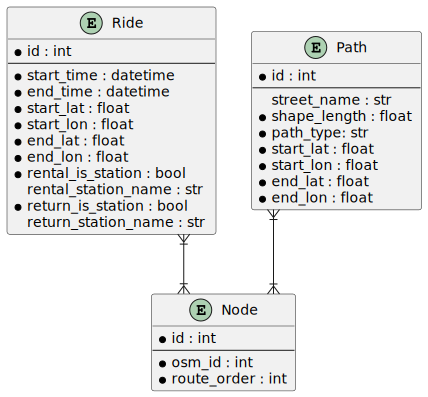

In [7]:
%%plantuml

@startuml

skinparam linetype ortho

entity Ride {
    * id : int
    --
    * start_time : datetime
    * end_time : datetime
    * start_lat : float
    * start_lon : float
    * end_lat : float
    * end_lon : float
    * rental_is_station : bool
    rental_station_name : str
    * return_is_station : bool
    return_station_name : str
}

entity Path {
    * id : int
    --
    street_name : str
    * shape_length : float
    * path_type: str
    * start_lat : float
    * start_lon : float
    * end_lat : float
    * end_lon : float
}

entity Node {
    * id : int
    --
    * osm_id : int
    * route_order : int
}

Ride }|--|{ Node
Path }|--|{ Node

@enduml

### Database Table Ride

In [8]:
ride_df = pd.read_sql_table("ride", con=engine, index_col="id")

ride_df.head()

,start_time,end_time,start_lat,start_lon,end_lat,end_lon,rental_is_station,rental_station_name,return_is_station,return_station_name
id,,,,,,,,,,
0,2022-10-08 03:02:00,2022-10-08 03:24:00,48.13289,11.52836,48.10425,11.56044,False,None,False,None
1,2022-08-13 18:59:00,2022-08-13 19:18:00,48.10349,11.55392,48.10039,11.55107,False,None,True,Tierpark
2,2022-09-05 19:41:00,2022-09-05 19:48:00,48.14038,11.57760,48.15021,11.57597,False,None,False,None
3,2022-06-04 14:09:00,2022-06-04 15:48:00,48.15835,11.75886,48.13833,11.58097,True,Bahnhof Süd Heimstetten,False,None
4,2022-06-28 17:25:00,2022-06-28 17:31:00,48.14475,11.56007,48.15018,11.56677,False,None,False,None


### Database Table Path

In [9]:
path_df = pd.read_sql_table("path", con=engine, index_col="id")

path_df.head()

,street_name,shape_length,path_type,start_lat,start_lon,end_lat,end_lon
id,,,,,,,
0,Blumenauer Straße,68.377238,Getrennter Rad- und Gehweg,48.140086,11.457012,48.139609,11.457590
1,Blumenauer Straße,7.453106,Getrennter Rad- und Gehweg,48.139609,11.457590,48.139573,11.457673
2,Haidelweg,23.496346,Getrennter Rad- und Gehweg,48.139609,11.457590,48.139399,11.457559
3,Hugo-Troendle-Straße,9.409103,Übergang,48.173685,11.511907,48.173768,11.511934
4,Lilienthalallee,4.733965,Übergang,48.191926,11.605764,48.191924,11.605828


### Database Table Node

In [10]:
node_df = pd.read_sql_table("node", con=engine, index_col="id")

node_df.head()

,osm_id,route_order
id,,
1,6611767667,0
2,6611767662,1
3,4482950351,2
4,4465362925,3
5,2008973815,4


### Visualization of a Ride Route

The plot shows the predicted route of an examplary bicycle ride (ID = 0) with the MVG Rad in the street map of Munich (provided by OSM).

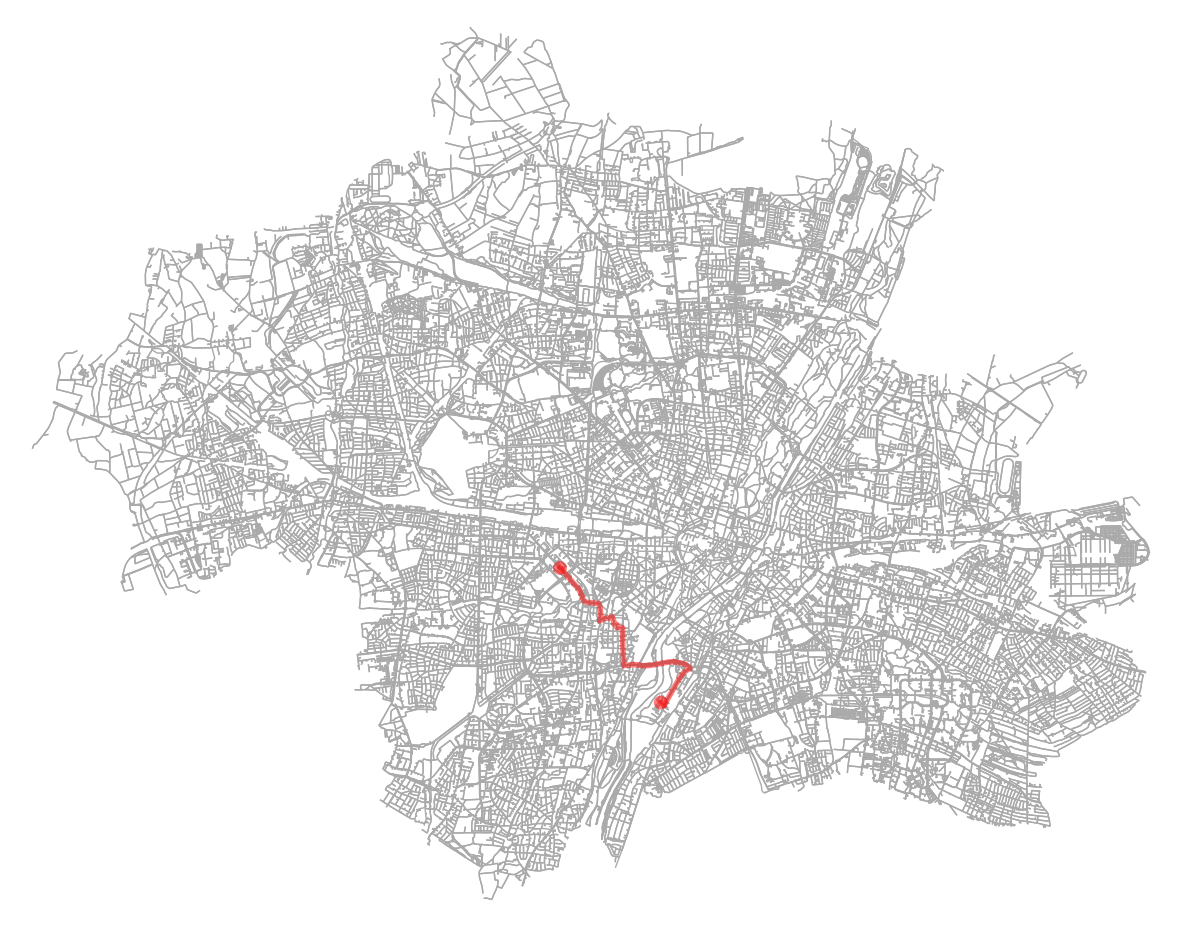

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [11]:
example_route_df = pd.read_sql_query(
    "SELECT n.osm_id FROM node n JOIN ride_node_mapping rnm ON n.id = rnm.node_id WHERE rnm.ride_id = 0 ORDER BY n.route_order ASC",
    con=engine)
example_route = example_route_df["osm_id"].tolist()

ox.plot_graph_route(graph, example_route, figsize=(15, 15), node_size=0, bgcolor="white", edge_color="#AAAAAA")

## Analysis

### a) Average Rides per Bicycle Path and Road per Month

This metric denotes the average number of MVG bike rides allocated to an infrastructure path in a given month. Thereby, it distinguishes between bike paths and bike roades, providing insights into the distribution of MVG bike rides across these two types of cycling infrastructure.

One notable challenge in the metric analysis pertains to the distortion of an absolute metric due to a minor fraction of the dataset. This issue compromises the precision and reliability of the findings, potentially engendering misleading interpretations. To address this concern and bolster the robustness of the metrics, a proposed solution involves the implementation of a weighting mechanism contingent on the ride_frac parameter. By incorporating this weighting factor, the influence of the problematic dataset fraction is intended to be mitigated, thus ensuring a more representative and accurate assessment of this metric. This strategic adjustment not only rectifies the current discrepancy but also contributes to the overall reliability and validity of the analytical approach.

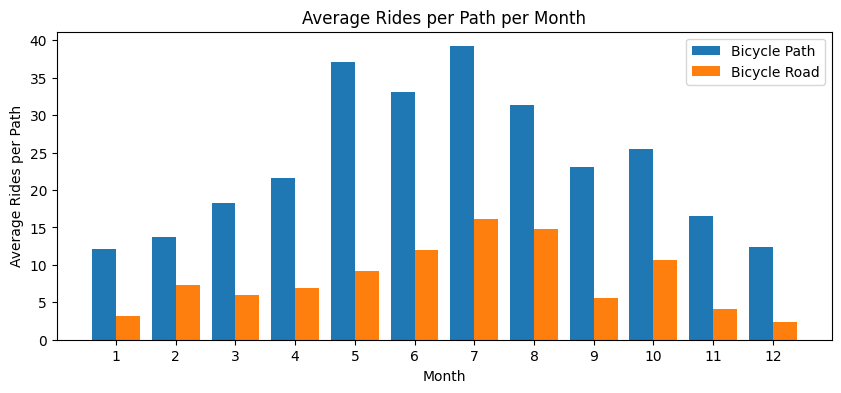

In [12]:
rides_per_bicycle_path_df = pd.read_sql_query("""
    SELECT p.id AS path_id, r.id AS ride_id, p.path_type, r.start_time
    FROM ((((path p JOIN path_node_mapping pnm ON p.id = pnm.path_id)
        JOIN node n1 ON pnm.node_id = n1.id)
        JOIN node n2 ON n2.osm_id = n1.osm_id)
        JOIN ride_node_mapping rnm ON n2.id = rnm.node_id)
        JOIN ride r ON rnm.ride_id = r.id
    WHERE p.path_type IN (
            'Radweg',
            'Radweg (Zweirichtungsradweg)',
            'Getrennter Rad- und Gehweg',
            'Getrennter Rad- und Gehweg (Zweirichtungsradweg)')
    GROUP BY p.id, r.id, p.path_type, r.start_time
    HAVING COUNT(*) = 2
""", con=engine)
rides_per_bicycle_road_df = pd.read_sql_query("""
    SELECT p.id AS path_id, r.id AS ride_id, p.path_type, r.start_time
    FROM ((((path p JOIN path_node_mapping pnm ON p.id = pnm.path_id)
        JOIN node n1 ON pnm.node_id = n1.id)
        JOIN node n2 ON n2.osm_id = n1.osm_id)
        JOIN ride_node_mapping rnm ON n2.id = rnm.node_id)
        JOIN ride r ON rnm.ride_id = r.id
    WHERE p.path_type = 'Fahrradstraße'
    GROUP BY p.id, r.id, p.path_type, r.start_time
    HAVING COUNT(*) = 2
""", con=engine)

bicycle_path_df = path_df[path_df["path_type"].isin([
    "Radweg",
    "Radweg (Zweirichtungsradweg)",
    "Getrennter Rad- und Gehweg",
    "Getrennter Rad- und Gehweg (Zweirichtungsradweg)"
])]
bicycle_road_df = path_df[path_df["path_type"] == "Fahrradstraße"]

month_list, avg_rides_per_bicycle_path_per_month_list = calc_rides_per_path(rides_per_bicycle_path_df, bicycle_path_df, total_counts_weight=1. / ride_frac)
_, avg_rides_per_bicycle_road_per_month_list = calc_rides_per_path(rides_per_bicycle_road_df, bicycle_road_df, total_counts_weight=1. / ride_frac)

half_bar_width = 0.2
x_axis_months = np.arange(len(month_list))

plt.figure(figsize=(10, 4))
plt.bar(x_axis_months - half_bar_width, avg_rides_per_bicycle_path_per_month_list, half_bar_width * 2, label="Bicycle Path")
plt.bar(x_axis_months + half_bar_width, avg_rides_per_bicycle_road_per_month_list, half_bar_width * 2, label="Bicycle Road")
plt.xticks(x_axis_months, month_list)
plt.legend()
plt.title("Average Rides per Path per Month")
plt.xlabel("Month")
plt.ylabel("Average Rides per Path")

plt.show()

### b) Average Share of Bicycle Paths and Roads per Ride per Month

This metric indicates the average proportion of MVG bike rides attributed to bike roades or bike paths, categorized by months. In this case, there is no need for a weighting because it only measures a percentage value that wouldn't profit from an equal weighting of the numerator and denominator.

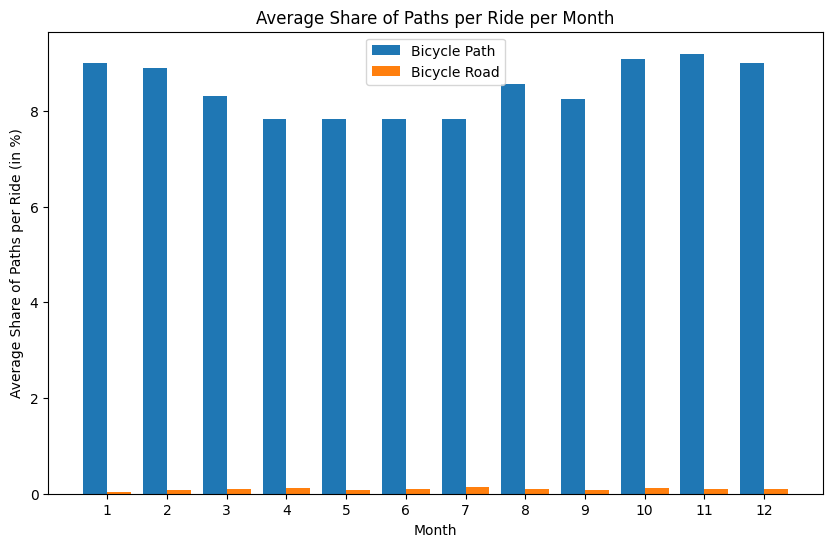

In [13]:
num_bicycle_paths_per_ride_df = pd.read_sql_query("""
    SELECT pr.ride_id, pr.start_time, COUNT(pr.path_id) AS num_paths
    FROM (
        SELECT r.id AS ride_id, p.id AS path_id, r.start_time
        FROM ((((ride r JOIN ride_node_mapping rnm ON r.id = rnm.ride_id)
            JOIN node n1 ON rnm.node_id = n1.id)
            JOIN node n2 ON n2.osm_id = n1.osm_id)
            JOIN path_node_mapping pnm ON n2.id = pnm.node_id)
            JOIN path p ON pnm.path_id = p.id
        WHERE p.path_type IN (
            'Radweg',
            'Radweg (Zweirichtungsradweg)',
            'Getrennter Rad- und Gehweg',
            'Getrennter Rad- und Gehweg (Zweirichtungsradweg)')
        GROUP BY r.id, p.id, r.start_time
        HAVING COUNT(*) = 2) AS pr
    GROUP BY pr.ride_id, pr.start_time
""", index_col="ride_id", con=engine)
num_bicycle_roads_per_ride_df = pd.read_sql_query("""
    SELECT pr.ride_id, pr.start_time, COUNT(pr.path_id) AS num_paths
    FROM (
        SELECT r.id AS ride_id, p.id AS path_id, r.start_time
        FROM ((((ride r JOIN ride_node_mapping rnm ON r.id = rnm.ride_id)
            JOIN node n1 ON rnm.node_id = n1.id)
            JOIN node n2 ON n2.osm_id = n1.osm_id)
            JOIN path_node_mapping pnm ON n2.id = pnm.node_id)
            JOIN path p ON pnm.path_id = p.id
        WHERE p.path_type = 'Fahrradstraße'
        GROUP BY r.id, p.id, r.start_time
        HAVING COUNT(*) = 2) AS pr
    GROUP BY pr.ride_id, pr.start_time
""", index_col="ride_id", con=engine)
num_edges_per_ride_df = pd.read_sql_query("""
    SELECT r.id AS ride_id, r.start_time, COUNT(rnm.node_id) - 1 AS num_edges
    FROM ride r JOIN ride_node_mapping rnm ON r.id = rnm.ride_id
    GROUP BY r.id, r.start_time
""", index_col="ride_id", con=engine)

month_list, avg_share_bicycle_paths_per_ride_per_month_list = calc_share_paths_per_ride(num_bicycle_paths_per_ride_df, num_edges_per_ride_df, ride_df)
_, avg_share_bicycle_roads_per_ride_per_month_list = calc_share_paths_per_ride(num_bicycle_roads_per_ride_df, num_edges_per_ride_df, ride_df)

half_bar_width = 0.2
x_axis_months = np.arange(len(month_list))

plt.figure(figsize=(10, 6))
plt.bar(x_axis_months - half_bar_width, avg_share_bicycle_paths_per_ride_per_month_list, half_bar_width * 2, label="Bicycle Path")
plt.bar(x_axis_months + half_bar_width, avg_share_bicycle_roads_per_ride_per_month_list, half_bar_width * 2, label="Bicycle Road")
plt.xticks(x_axis_months, month_list)
plt.legend()
plt.title("Average Share of Paths per Ride per Month")
plt.xlabel("Month")
plt.ylabel("Average Share of Paths per Ride (in %)")

plt.show()

## Conclusion

In summary, the exploration of Munich's regional bicycle infrastructure and its impact on the use of the MVG rental bike service has yielded significant insights. Metric a) underscores a robust correlation between the provided infrastructure, comprising bike paths and bike lanes in Munich, and the prevalence of MVG Rad rides. This highlights the pivotal role of dedicated cycling infrastructure in shaping the adoption patterns of bike-sharing systems within urban contexts.

Additionally, Metric a) illuminates a temporal concentration of MVG Rad usage during the summer months. This observed seasonal variation aligns intuitively with higher bicycle usage in warmer weather, as reflected in the MVG dataset. The correlation between seasonal patterns and bike-sharing underscores the nuanced interplay between environmental factors and mobility preferences.

Contrastingly, Metric b) reveals a relatively low percentage of MVG Rad routes traversing bike paths or especially bike roads. This suggests potential preferences for the calculated routes that tend to utilize regular streets or points to an inadequacy in Munich's infrastructure in providing dedicated cycling paths.

However, these interpretations are subject to several limitations. The analysis relies on a significantly reduced MVG dataset due to computational constraints, limiting the depth of our insights. The calculation of the shortest route for individual MVG Rad rides is based solely on estimated travel time and start/end points, lacking precise route information. Furthermore, potential inaccuracies may arise from the conversion of UTM coordinates in the Path dataset and the calculation of the nearest OSM nodes based on longitude and latitude coordinates.

It is essential to note that the metrics establish a connection between a ride and a path only when the entire path is traversed, potentially leading to disparities between the OSM graph and the data provided by the Baureferat. Additionally, the analysis is confined solely to Munich's data, limiting the generalizability of findings to other cities and bike-sharing service providers.

Looking ahead, addressing these limitations would be imperative for refining the comprehensiveness of future investigations. Incorporating the whole MVG dataset and employing advanced methodologies could enhance the depth and accuracy of our analyses. Furthermore, extending the study to encompass data from other cities and diverse bike-sharing providers would contribute to a more comprehensive understanding of the universal and context-specific aspects of bike-sharing utilization.

In conclusion, while this study sheds light on the intricate relationship between urban bicycle infrastructure and the MVG rental bike service in Munich, ongoing research endeavors are essential for refining our understanding and advancing the broader discourse on sustainable urban mobility. This study lays the groundwork for future investigations, emphasizing the importance of considering nuanced environmental and infrastructural factors in shaping urban mobility patterns.